# Child Growth Data
Source of data: https://www.kaggle.com/datasets/remcogeervliet/max-foundation-bangladesh-child-growth-data/data



# 1. Data Exploration

## 1.1) Import Libraries

In [1]:
import pandas as pd
import numpy as np
import kagglehub
import math

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import datetime as dt
from datetime import datetime

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder


from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

c:\Users\Andres\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.2) Load Data from kagle

In [2]:
! pip install kagglehub



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import the data
data = kagglehub.dataset_download("remcogeervliet/max-foundation-bangladesh-child-growth-data")

In [4]:
# Lire le fichier avec l'encodage détecté
data = pd.read_csv(data + '\\BD_growth_prog_anon.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486267 entries, 0 to 486266
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               486267 non-null  int64  
 1   district                 486267 non-null  object 
 2   upazila                  486267 non-null  int64  
 3   union                    486267 non-null  int64  
 4   village                  486267 non-null  int64  
 5   hh_id                    486267 non-null  int64  
 6   child_id                 486267 non-null  int64  
 7   date                     486267 non-null  object 
 8   gender                   486267 non-null  object 
 9   dob                      485472 non-null  object 
 10  height                   483203 non-null  float64
 11  weight                   483203 non-null  float64
 12  cbmi                     482383 non-null  float64
 13  zlen                     475081 non-null  float64
 14  flen

### 1.2.1) Compress Data
Let's compress the dataframe by lowering its numeric dtypes
* from float64 to float32
* from int64 to int8

In [5]:
def compress(df, **kwargs):
    """
    Reduces the size of the DataFrame by downcasting numerical columns
    """
    input_size = df.memory_usage(index=True).sum()/ 1024**2
    print("old dataframe size: ", round(input_size,2), 'MB')

    in_size = df.memory_usage(index=True).sum()

    for t in ["float", "integer"]:
        l_cols = list(df.select_dtypes(include=t))

        for col in l_cols:
            df[col] = pd.to_numeric(df[col], downcast=t)

    out_size = df.memory_usage(index=True).sum()
    ratio = (1 - round(out_size / in_size, 2)) * 100

    print("optimized size by {} %".format(round(ratio,2)))
    print("new DataFrame size: ", round(out_size / 1024**2,2), " MB")

    return df

In [6]:
data= compress(data, verbose=True)
data.head(1)

old dataframe size:  107.59 MB
optimized size by 50.0 %
new DataFrame size:  53.33  MB


,Unnamed: 0,district,upazila,union,village,hh_id,child_id,date,gender,dob,...,zbmi,fbmi,flag_duplicated_day,flag_duplicated_quarter,flag_obs_number,flag_different_dob,flag_dob_number,flag_under_zero,flag_no_match,flag_flip
0,1,Patuakhali,7895,789531,961,181000001,181000001,2021-04-01,M,2014-01-01,...,NaN,NaN,0,0,1,0,1.0,0,0,0


## 1.3) Clean Data. Exploratory Data Analysis


In [7]:
data.describe()

c:\Users\Andres\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\Andres\Python\Python310\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Unnamed: 0,upazila,union,village,hh_id,child_id,height,weight,cbmi,zlen,...,zbmi,fbmi,flag_duplicated_day,flag_duplicated_quarter,flag_obs_number,flag_different_dob,flag_dob_number,flag_under_zero,flag_no_match,flag_flip
count,486267.000000,486267.000000,486267.000000,486267.000000,4.862670e+05,4.862670e+05,483203.000000,483203.000000,482383.0,475081.000000,...,475081.0,475081.000000,486267.000000,486267.000000,486267.000000,486267.000000,485472.000000,486267.000000,486267.000000,486267.000000
mean,243134.000000,6541.031781,654151.522571,839.266078,1.901757e+08,1.914057e+08,84.067986,11.823614,inf,-1.982482,...,inf,0.050692,0.028365,0.553751,1.487068,0.001551,1.000777,0.000012,0.001635,0.003029
std,140373.336012,2358.514712,235848.203809,495.438185,7.670967e+06,8.244706e+06,148.992981,47.308174,NaN,42.713688,...,NaN,0.219369,0.166014,0.497103,0.803718,0.039347,0.027856,0.003513,0.040401,0.054955
min,1.000000,409.000000,40923.000000,1.000000,1.810000e+08,1.810000e+08,0.000000,0.000000,0.0,-31.799999,...,-16.9,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,121567.500000,4730.000000,473033.000000,397.000000,1.840110e+08,1.840163e+08,74.000000,9.000000,14.4,-3.500000,...,-0.9,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,243134.000000,7857.000000,785767.000000,837.000000,1.910012e+08,1.910060e+08,84.000000,11.000000,15.7,-1.700000,...,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,364700.500000,7897.000000,789734.000000,1279.000000,1.940007e+08,1.940043e+08,94.000000,14.000000,17.8,-0.600000,...,1.4,0.000000,0.000000,1.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,486267.000000,8790.000000,879079.000000,1674.000000,2.180000e+08,2.180000e+08,97100.000000,14799.000000,inf,27587.500000,...,inf,1.000000,1.000000,1.000000,14.000000,1.000000,2.000000,1.000000,1.000000,1.000000


**Profiling alerts for the presence of 4 potential data quality problems:**
* **IMBALANCE**: flen, fwei, fwfl, fbmi,
flag_duplicated_day, flag_different_dob, flag_dob_numbe, flag_under_zero, flag_no_match, flag_flip
* **MISSING**: zlen, flen, zwei, fwei, zwfl, fwfl, zbmi, fbmi,
* **SKEWED**: height, weight, zlen, zwei.
* **ZEROS**: zlen, zwei, zwfl, zbmi.

In [8]:
data = data[['district','upazila','union','village','hh_id','child_id','date','gender','dob','height','weight','cbmi','zlen','flen','zwei','fwei','zwfl','fwfl','zbmi','fbmi']]

**Removing Duplicate**


In [9]:
data.duplicated().sum()

np.int64(707)

**Missing Data**

In [10]:
data.isna().sum().sort_values(ascending=False)/len(data) * 100

fwfl        4.343910
zwfl        4.343910
zbmi        2.300382
fbmi        2.300382
flen        2.300382
zlen        2.300382
zwei        2.300382
fwei        2.300382
cbmi        0.798738
height      0.630107
weight      0.630107
dob         0.163490
village     0.000000
union       0.000000
upazila     0.000000
district    0.000000
hh_id       0.000000
child_id    0.000000
date        0.000000
gender      0.000000
dtype: float64

**Adjust the data implement WHO guidelines** \
This eliminates the zeros the null data and adjusts the imbalance \
I chose to delete NaN data because it is less than 1 percent of the data \
Check zeros in columns

In [11]:
# Values outside the biologically possible ranges according Anthro WHO
df_transformed = data[
    (data['zlen'].between(-6, 6)) &
    (data['zwei'].between(-6, 6)) &
    (data['zwfl'].between(-5, 5)) &
    (data['zbmi'].between(-5, 5))
]
df_transformed.head()

,district,upazila,union,village,hh_id,child_id,date,gender,dob,height,weight,cbmi,zlen,flen,zwei,fwei,zwfl,fwfl,zbmi,fbmi
2,Patuakhali,7857,785737,1659,181000002,181000002,2019-10-01,M,2018-01-01,71.0,12.0,21.7,-4.6,0.0,-0.2,0.0,2.8,0.0,3.7,0.0
3,Patuakhali,7857,785737,1659,181000002,181000002,2019-10-01,M,2018-01-01,74.0,11.0,22.5,-4.3,0.0,0.2,0.0,3.2,0.0,4.2,0.0
4,Patuakhali,7857,785737,1659,181000002,181000002,2020-01-01,M,2018-01-01,75.0,12.0,22.2,-4.2,0.0,0.2,0.0,3.1,0.0,4.1,0.0
5,Patuakhali,7857,785737,1659,181000002,181000002,2020-01-01,M,2018-01-01,76.0,12.0,21.6,-4.0,0.0,0.1,0.0,2.8,0.0,3.8,0.0
6,Patuakhali,7857,785737,1659,181000002,181000002,2020-07-01,M,2018-01-01,79.0,13.0,20.3,-3.8,0.0,-0.4,0.0,2.3,0.0,3.0,0.0


In [12]:
df_transformed.isna().sum().sort_values(ascending=False)

district    0
upazila     0
union       0
village     0
hh_id       0
child_id    0
date        0
gender      0
dob         0
height      0
weight      0
cbmi        0
zlen        0
flen        0
zwei        0
fwei        0
zwfl        0
fwfl        0
zbmi        0
fbmi        0
dtype: int64

**Transform date to datetime format**

In [13]:
df_transformed.loc[:, 'date'] = pd.to_datetime(df_transformed.loc[:, 'date'], errors='coerce', format='%Y-%m-%d')
df_transformed.loc[:, 'dob'] = pd.to_datetime(df_transformed.loc[:, 'dob'], errors='coerce', format='%Y-%m-%d')


In [14]:
df_transformed['date'] = df_transformed['date'].apply(lambda x: x.to_pydatetime())
df_transformed['dob'] = df_transformed['dob'].apply(lambda x: x.to_pydatetime())

C:\Users\Andres\AppData\Local\Temp\ipykernel_9992\1836061915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed['date'] = df_transformed['date'].apply(lambda x: x.to_pydatetime())
C:\Users\Andres\AppData\Local\Temp\ipykernel_9992\1836061915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed['dob'] = df_transformed['dob'].apply(lambda x: x.to_pydatetime())


In [15]:
print(df_transformed['date'].unique())


<DatetimeArray>
['2019-10-01 00:00:00', '2020-01-01 00:00:00', '2020-07-01 00:00:00',
 '2020-10-01 00:00:00', '2021-01-01 00:00:00', '2021-04-01 00:00:00',
 '2021-07-01 00:00:00', '2021-10-01 00:00:00', '2019-07-01 00:00:00',
 '2020-04-01 00:00:00', '2018-07-01 00:00:00', '2018-10-01 00:00:00',
 '2019-01-01 00:00:00', '2019-04-01 00:00:00']
Length: 14, dtype: datetime64[ns]


**Check for NaN or Null values after transformation**

In [16]:
df_transformed.isna().sum()

district    0
upazila     0
union       0
village     0
hh_id       0
child_id    0
date        0
gender      0
dob         0
height      0
weight      0
cbmi        0
zlen        0
flen        0
zwei        0
fwei        0
zwfl        0
fwfl        0
zbmi        0
fbmi        0
dtype: int64

In [17]:
df_transformed.isnull().sum().sort_values(ascending=False) / len(data)

district    0.0
upazila     0.0
union       0.0
village     0.0
hh_id       0.0
child_id    0.0
date        0.0
gender      0.0
dob         0.0
height      0.0
weight      0.0
cbmi        0.0
zlen        0.0
flen        0.0
zwei        0.0
fwei        0.0
zwfl        0.0
fwfl        0.0
zbmi        0.0
fbmi        0.0
dtype: float64

## 1.4) Data Visualization

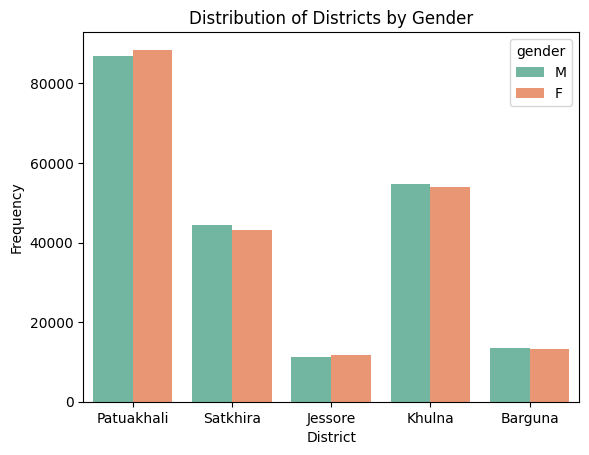

In [18]:
zones = sns.countplot(x="district", hue= 'gender', data= df_transformed, palette= "Set2")
zones.set(xlabel='District', ylabel='Frequency', title='Distribution of Districts by Gender');

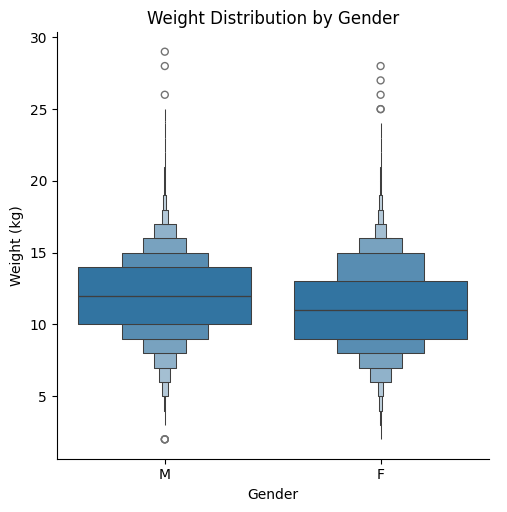

In [19]:
outliers_weight = sns.catplot(x='gender', y='weight', data= df_transformed, kind = 'boxen')
outliers_weight.set(xlabel='Gender', ylabel='Weight (kg)', title='Weight Distribution by Gender');

In [20]:
#histo = sns.displot(df_transformed, x= 'weight', hue= 'gender', multiple="stack", bins=25)
#histo.figure.set_size_inches(4,6)
#histo.set(xlabel='Weight (kg)', ylabel='Frequency', title='Weight Distribution of Total Observations');

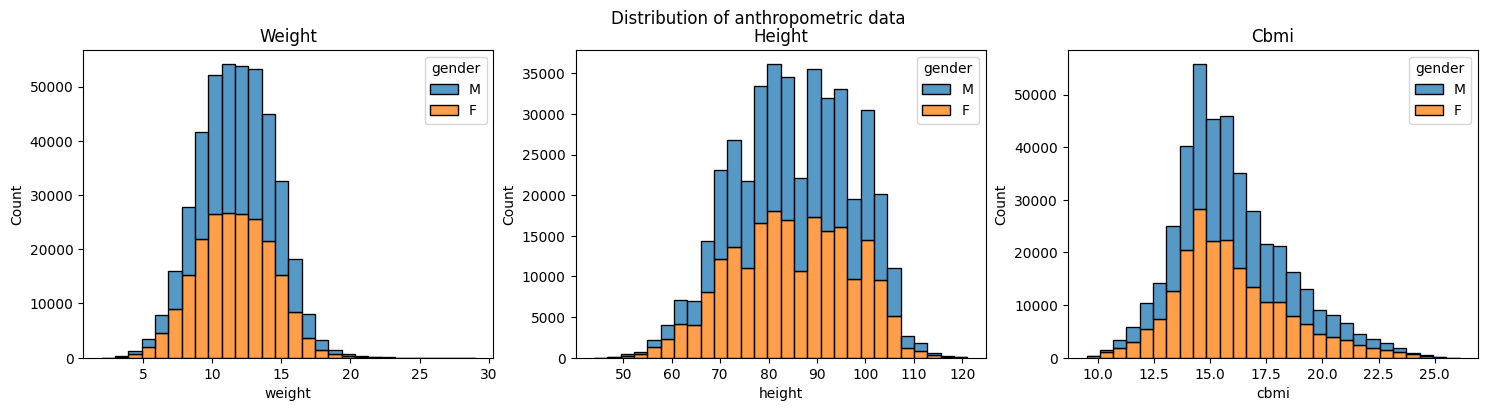

In [21]:
def graph_plot(df, list_x):
  fig, axs = plt.subplots(1, len(list_x), figsize=(18, 4))

  for i, col in enumerate(list_x):
    sns.histplot(data=df,
                 x= col,
                 hue= 'gender',
                 multiple="stack",
                 bins=28,
                 ax=axs[i])
    axs[i].set_title(col.capitalize())
    fig.suptitle('Distribution of anthropometric data')

graph_plot(df_transformed, ['weight','height','cbmi'])

**OneHotEncoding for the categorical variables**

In [22]:

# Instantiate the OneHotEncoder
ordinal_encoder = OrdinalEncoder()
# Fit encoder
ordinal_encoder.fit((df_transformed[['district', 'gender']]))
# Display the learned categories
display(ordinal_encoder.categories_)

# Transform categories into ordered numbers
df_transformed[['district', 'gender']] = ordinal_encoder.transform(df_transformed[['district', 'gender']])

# Show the dataset
df_transformed.head(3)

[array(['Barguna', 'Jessore', 'Khulna', 'Patuakhali', 'Satkhira'],
       dtype=object),
 array(['F', 'M'], dtype=object)]

C:\Users\Andres\AppData\Local\Temp\ipykernel_9992\3972922373.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed[['district', 'gender']] = ordinal_encoder.transform(df_transformed[['district', 'gender']])


,district,upazila,union,village,hh_id,child_id,date,gender,dob,height,weight,cbmi,zlen,flen,zwei,fwei,zwfl,fwfl,zbmi,fbmi
2,3.0,7857,785737,1659,181000002,181000002,2019-10-01,1.0,2018-01-01,71.0,12.0,21.7,-4.6,0.0,-0.2,0.0,2.8,0.0,3.7,0.0
3,3.0,7857,785737,1659,181000002,181000002,2019-10-01,1.0,2018-01-01,74.0,11.0,22.5,-4.3,0.0,0.2,0.0,3.2,0.0,4.2,0.0
4,3.0,7857,785737,1659,181000002,181000002,2020-01-01,1.0,2018-01-01,75.0,12.0,22.2,-4.2,0.0,0.2,0.0,3.1,0.0,4.1,0.0


In [23]:
df_transformed.loc[:, 'age_in_months'] = ((df_transformed.loc[:, 'date'].dt.year - df_transformed.loc[:, 'dob'].dt.year) * 12 +
                                        (df_transformed.loc[:, 'date'].dt.month - df_transformed.loc[:, 'dob'].dt.month)
                                        )
print(df_transformed['age_in_months'])

C:\Users\Andres\AppData\Local\Temp\ipykernel_9992\996624042.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed.loc[:, 'age_in_months'] = ((df_transformed.loc[:, 'date'].dt.year - df_transformed.loc[:, 'dob'].dt.year) * 12 +


2         21
3         21
4         24
5         24
6         30
          ..
486244     9
486245     9
486246     9
486247     6
486248     3
Name: age_in_months, Length: 420947, dtype: int32


**Correlation Matrix**

<Axes: >

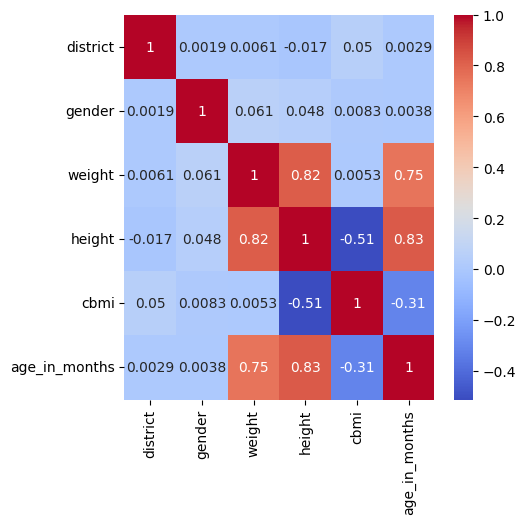

In [24]:
plt.figure(figsize = (5, 5))

sns.heatmap(
    df_transformed[['district','gender','weight','height','cbmi', 'age_in_months']].corr(),
    cmap = 'coolwarm',
    annot = True,
    annot_kws = {"size": 10}
)

There are 4 Correlations highlighted:
1. weight and height (height): They have a high positive correlation (0.82), which is expected because weight and height are usually related.
2. height and age_in_months: High correlation (0.83), suggesting that older children tend to be taller.
3. weight and age_in_months: Significant positive correlation (0.75), indicating that as children grow up their weight increases. 
4. height and cbmi: Negative correlation (-0.51), possibly because the adjusted BMI decreases as the height increases in certain contexts.

**Nutritional classification according to ZScore for length and BMI**

Sometimes when children are stunted at the same time they are overweight so it is important to chek both parameters

In [25]:
#Count the numbers observations 
df_transformed['obs_num'] = df_transformed.groupby('child_id').cumcount() + 1

df_transformed['stunt'] = df_transformed['zlen'].apply(lambda x: True if x <= -2 else False) * 1

df_transformed

C:\Users\Andres\AppData\Local\Temp\ipykernel_9992\1410612224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed['obs_num'] = df_transformed.groupby('child_id').cumcount() + 1
C:\Users\Andres\AppData\Local\Temp\ipykernel_9992\1410612224.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed['stunt'] = df_transformed['zlen'].apply(lambda x: True if x <= -2 else False) * 1


,district,upazila,union,village,hh_id,child_id,date,gender,dob,height,...,flen,zwei,fwei,zwfl,fwfl,zbmi,fbmi,age_in_months,obs_num,stunt
2,3.0,7857,785737,1659,181000002,181000002,2019-10-01,1.0,2018-01-01,71.0,...,0.0,-0.2,0.0,2.8,0.0,3.7,0.0,21,1,1
3,3.0,7857,785737,1659,181000002,181000002,2019-10-01,1.0,2018-01-01,74.0,...,0.0,0.2,0.0,3.2,0.0,4.2,0.0,21,2,1
4,3.0,7857,785737,1659,181000002,181000002,2020-01-01,1.0,2018-01-01,75.0,...,0.0,0.2,0.0,3.1,0.0,4.1,0.0,24,3,1
5,3.0,7857,785737,1659,181000002,181000002,2020-01-01,1.0,2018-01-01,76.0,...,0.0,0.1,0.0,2.8,0.0,3.8,0.0,24,4,1
6,3.0,7857,785737,1659,181000002,181000002,2020-07-01,1.0,2018-01-01,79.0,...,0.0,-0.4,0.0,2.3,0.0,3.0,0.0,30,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486244,3.0,7857,785755,813,191002449,213001053,2021-10-01,0.0,2021-01-01,61.0,...,0.0,-0.5,0.0,1.7,0.0,1.4,0.0,9,1,1
486245,3.0,7857,785755,813,191002449,213001053,2021-10-01,0.0,2021-01-01,61.0,...,0.0,-0.8,0.0,1.5,0.0,1.3,0.0,9,2,1
486246,0.0,409,40963,1419,213001054,213001054,2021-10-01,0.0,2021-01-01,69.0,...,0.0,0.2,0.0,-0.2,0.0,-0.3,0.0,9,1,0
486247,2.0,4764,476427,486,214000247,214000247,2021-10-01,1.0,2021-04-01,62.0,...,0.0,0.0,0.0,1.9,0.0,1.6,0.0,6,1,1


In [26]:
# Define the boundaries of bins and labels by Antro WHO
bins_zlen = [-float('inf'), -3, -2, -1, float('inf')]  
labels_zlen = ["Severely Stunted", "Stunted", "At Risk", "Normal"]

bins_zbmi = [-float('inf'), -3, -2, 2, 3, float('inf')] 
labels_zbmi = ["Severely thin", "Thin", "Normal", "Overweight", "Obese"]
# Create the column categorical 
df_transformed.loc[:,'zlen_cat'] = pd.cut(df_transformed.loc[:,'zlen'], bins=bins_zlen, labels=labels_zlen)

df_transformed.loc[:,'zbmi_cat'] = pd.cut(df_transformed.loc[:, 'zbmi'], bins=bins_zbmi, labels=labels_zbmi)
print(df_transformed.head())

   district  upazila   union  village      hh_id   child_id       date  \
2       3.0     7857  785737     1659  181000002  181000002 2019-10-01   
3       3.0     7857  785737     1659  181000002  181000002 2019-10-01   
4       3.0     7857  785737     1659  181000002  181000002 2020-01-01   
5       3.0     7857  785737     1659  181000002  181000002 2020-01-01   
6       3.0     7857  785737     1659  181000002  181000002 2020-07-01   

   gender        dob  height  ...  fwei  zwfl  fwfl  zbmi  fbmi  \
2     1.0 2018-01-01    71.0  ...   0.0   2.8   0.0   3.7   0.0   
3     1.0 2018-01-01    74.0  ...   0.0   3.2   0.0   4.2   0.0   
4     1.0 2018-01-01    75.0  ...   0.0   3.1   0.0   4.1   0.0   
5     1.0 2018-01-01    76.0  ...   0.0   2.8   0.0   3.8   0.0   
6     1.0 2018-01-01    79.0  ...   0.0   2.3   0.0   3.0   0.0   

   age_in_months  obs_num  stunt          zlen_cat    zbmi_cat  
2             21        1      1  Severely Stunted       Obese  
3             21      

C:\Users\Andres\AppData\Local\Temp\ipykernel_9992\2758394886.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed.loc[:,'zlen_cat'] = pd.cut(df_transformed.loc[:,'zlen'], bins=bins_zlen, labels=labels_zlen)
C:\Users\Andres\AppData\Local\Temp\ipykernel_9992\2758394886.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_transformed.loc[:,'zbmi_cat'] = pd.cut(df_transformed.loc[:, 'zbmi'], bins=bins_zbmi, labels=labels_zbmi)


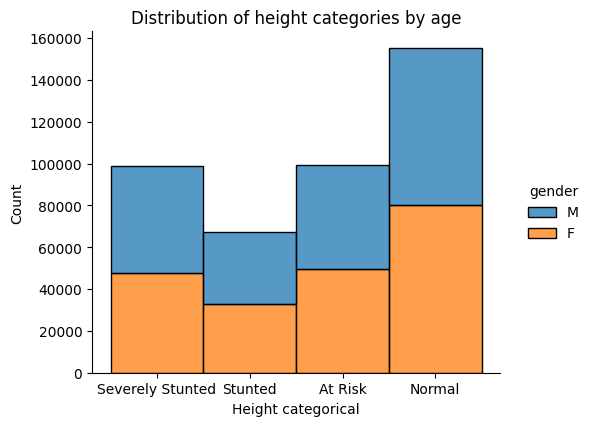

In [27]:
histo = sns.displot(df_transformed.assign(gender=df_transformed['gender'].map({0: 'F', 1: 'M'})), x= 'zlen_cat', hue= 'gender', multiple="stack", bins=20)
histo.figure.set_size_inches(6, 4)
histo.set(xlabel='Height categorical', ylabel='Count', title='Distribution of height categories by age');


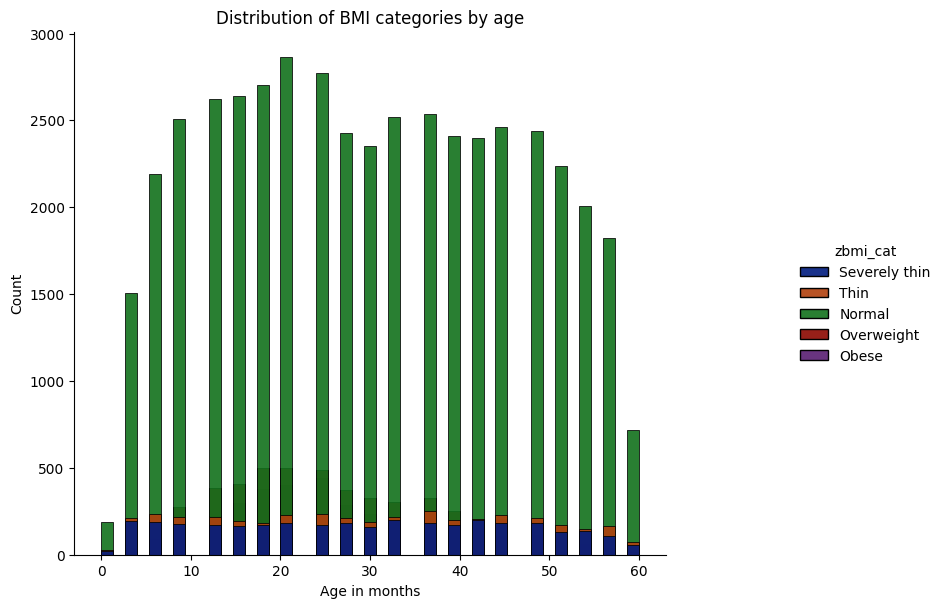

In [28]:
firts_id = df_transformed['obs_num'] == 1

first_child_id = df_transformed[df_transformed['obs_num'] == firts_id]

histo = sns.displot(first_child_id, x='age_in_months', hue= 'zbmi_cat',
                  palette="dark", alpha=.9,
                    height=6, aspect=.75,
                       )
histo.figure.set_size_inches(10,6)
histo.set(xlabel='Age in months', ylabel='Count', title='Distribution of BMI categories by age');

In [29]:
df_transformed = df_transformed.sort_values(['child_id', 'obs_num'])

# Calculate recovery time
recovery_times = []
for child_id, group in df_transformed.groupby('child_id'):
    stunted = group[group['stunt'] == 1]
    recovered = group[group['stunt'] == 0]
    if not stunted.empty and not recovered.empty:
        first_stunt_time = stunted['obs_num'].iloc[0]
        first_recovery_time = recovered['obs_num'].iloc[0]
        if first_recovery_time > first_stunt_time:
            recovery_times.append(first_recovery_time - first_stunt_time)

# Average recovery time
average_recovery_time = sum(recovery_times) / len(recovery_times)
print(f"Average recovery time: {average_recovery_time:.2f} observations")

Average recovery time: 3.33 observations


## 2) Linear Regression Model

First model \
Check the relationship between weight and other variables such as sex, district, age and number of observations

In [30]:
model = smf.ols(formula = 'weight ~  obs_num + gender + district + age_in_months' , data= df_transformed)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                 1.423e+05
Date:                Sun, 12 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:55:11   Log-Likelihood:            -8.4804e+05
No. Observations:              420947   AIC:                         1.696e+06
Df Residuals:                  420942   BIC:                         1.696e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.7282      0.011    632.669

**Analysis**
- **R-squared** The 57.5% of the variability in weight is explained by variables included in the model
- **Intercept** The weigth is 6.7 when all the variable are 0. 
- **Gender**  Being male is associated with an average increase of 0.3317 in weight.

Second Model \  
Regresion logistic model 


In [31]:

model2 = smf.logit(formula = 'stunt ~ obs_num + age_in_months + gender + C(district)' , data= df_transformed)
results = model2.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.650719
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  stunt   No. Observations:               420947
Model:                          Logit   Df Residuals:                   420939
Method:                           MLE   Df Model:                            7
Date:                Sun, 12 Jan 2025   Pseudo R-squ.:                 0.02999
Time:                        16:55:14   Log-Likelihood:            -2.7392e+05
converged:                       True   LL-Null:                   -2.8239e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3737      0.015     24.786      0.000       0.344       0.403
C(dis

**Analysis**
- **Pseudo R-squared** It's near at the first model, with a fairly good fit,

In [32]:
# Given log-odds
log_odds = 0.3737
odds = math.exp(log_odds)

#Calculate probability
probability = odds / (1 + odds)

print(f"The model assigns with {probability:.2%} probability that an individual who is classified as stunt")

The model assigns with 59.24% probability that an individual who is classified as stunt


In [33]:
intercept = 0.3737
coefficients = {
    'obs_num': -0.0916,
    'age_in_months': -0.0007,
    'gender': 0.0920,
    'district': {0:0, 1: -0.46640, 2: -0.7252, 3: -0.2579, 4:  -0.2169}
}

# Calculate log-odds
log_odds = (intercept
            + coefficients['obs_num'] * df_transformed['obs_num']
            + coefficients['age_in_months'] * df_transformed['age_in_months']
            + coefficients['gender'] * df_transformed['gender']
            + df_transformed['district'].map(coefficients['district']))

# Convert log-odds to probabilities
df_transformed['probability'] = 1 / (1 + np.exp(-log_odds))
#print(df_transformed['probability'])

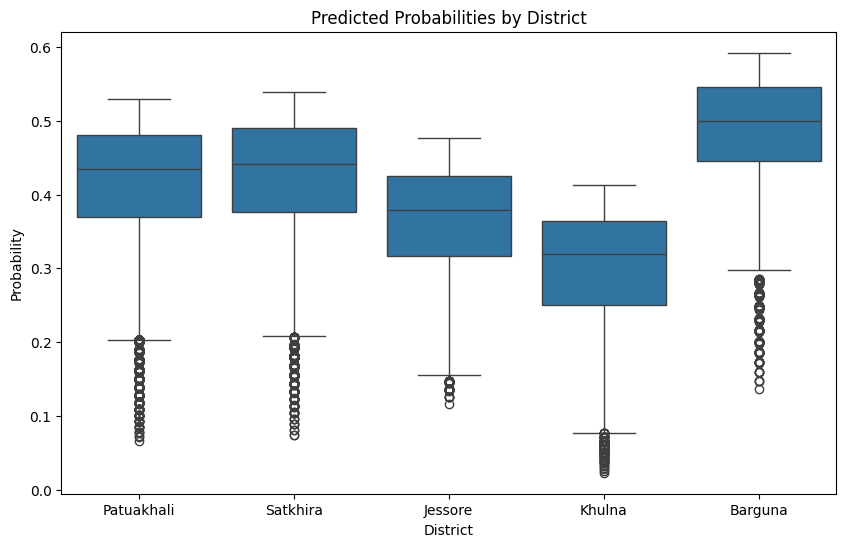

In [34]:
# Boxplot of probabilities across districts
plt.figure(figsize=(10, 6))
sns.boxplot(df_transformed.assign(district=df_transformed['district'].map({0: 'Barguna', 1: 'Jessore', 2: 'Khulna', 3: 'Patuakhali', 4: 'Satkhira'})), x='district', y='probability')
plt.title('Predicted Probabilities by District')
plt.xlabel('District')
plt.ylabel('Probability')
plt.show()

- *District Barguna* appears to have the highest predicted probabilities of stunt overall, suggesting a higher likelihood of stunting for individuals in this district compared to others.
- *Districts Khulna and Jessore* have notably lower probabilities, indicating that individuals in these districts are less likely to be predicted as stunted.

In [35]:
new_data = pd.DataFrame({
    'weight': [12],            
    'age_in_months': [24],     
    'gender': [1],             
    'district': [2],
    'obs_num': [4]            
})

# Predict the probability of recovery
probability = results.predict(new_data)
print(f" Probability of recovery: {probability.iloc[0]:.2%}")

 Probability of recovery: 34.47%
